# Imports

In [1]:
import os

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import cv2

from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

# Data

In [2]:
class SouthParkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.paths = []
        for dir, subdir, files in os.walk(self.root_dir):
            for file in files:
                self.paths.append(os.path.join(dir, file))

    @staticmethod
    def __read_img(path) -> torch.Tensor:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        return image
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.__read_img(self.paths[idx])

        if self.transform:
            image = self.transform(image)

        return image

In [3]:
dataset = SouthParkDataset(root_dir="single_character_data", transform=None)
len(dataset)

906

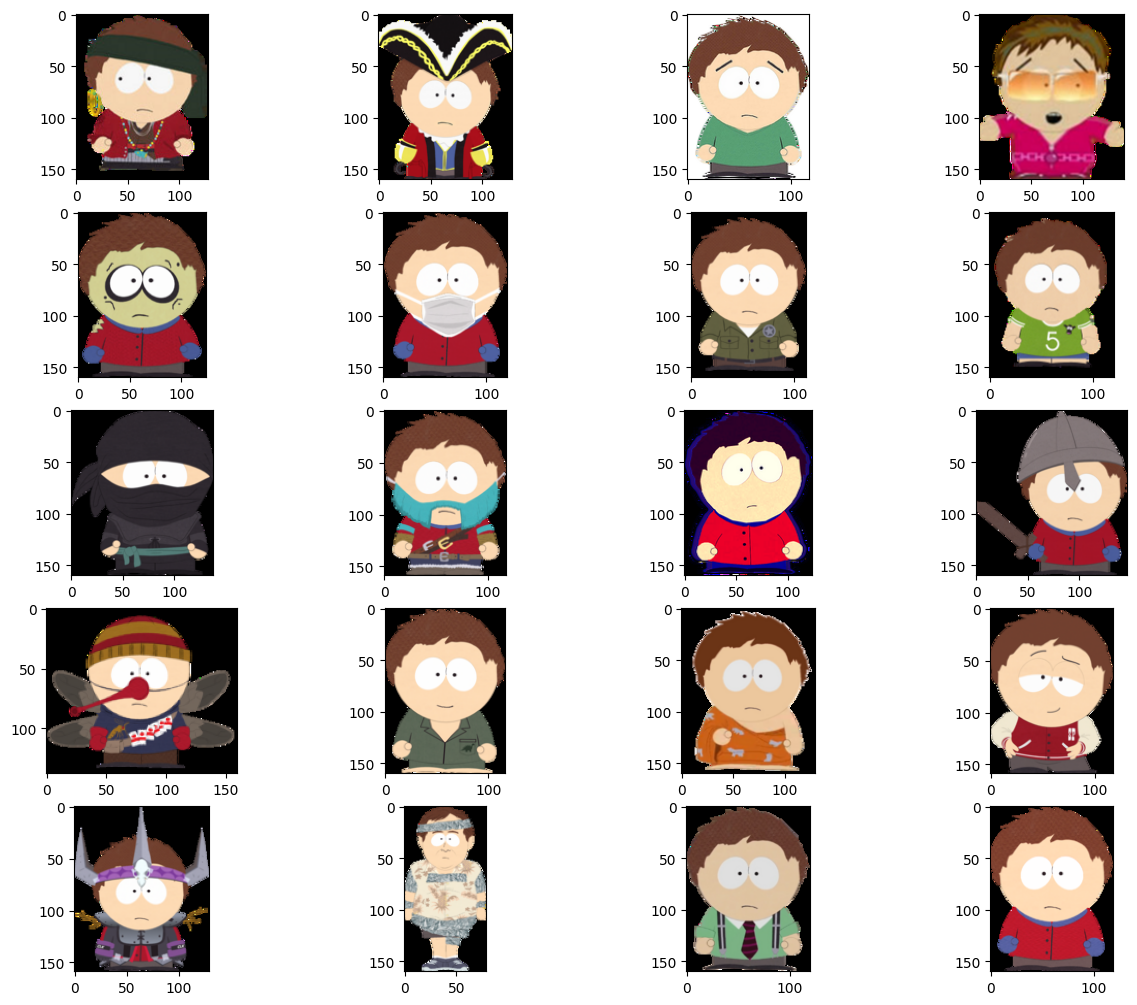

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt


def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)



show_images(dataset)

# Transforms

In [5]:
IMG_SIZE = 32
BATCH_SIZE = 16


def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])

    dataset = SouthParkDataset(root_dir="single_character_data", transform=data_transforms)
    
    return dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0]
        
    plt.imshow(reverse_transforms(image))

    
train_dataset = load_transformed_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/Users/user/PycharmProjects/south-park-character-generation/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


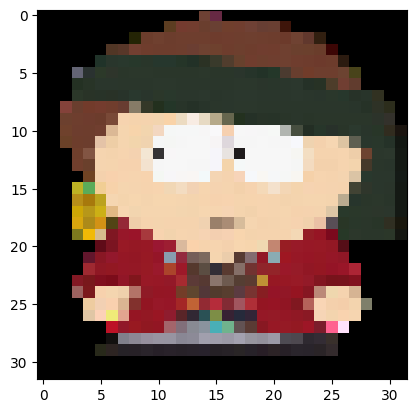

In [6]:
show_tensor_image(train_dataset[0])

# Model

In [7]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim

        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.flatten = nn.Flatten()

        self.mu = nn.Sequential(
            nn.Linear(self.encoder[-3].out_channels * 2 * 2, z_dim * 4),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        self.log_var = nn.Sequential(
            nn.Linear(self.encoder[-3].out_channels * 2 * 2, z_dim * 4),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.flatten(self.encoder(x))
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var
        
    def decode(self, z):
        x_rec = self.decoder(z)
        return x_rec

    def reparametrize(self, mu, log_var):
        epsilon = torch.Tensor(np.random.normal(size=(self.z_dim * 4), scale=1.0)).to(mu.device)
        return mu + epsilon * torch.exp(log_var / 2)
        
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var).reshape((x.shape[0], self.z_dim, 2, 2))
        x_rec = self.decode(z)

        return x_rec, mu, log_var

# Loss

In [8]:
def kl_div_loss(mu, log_var):
    kl = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    return kl

# Loops

In [9]:
def sample(model):
    model.eval()
    with torch.no_grad():
        output = model.decode(torch.tensor(np.random.normal(size=(1, 64, 2, 2), scale=1.0).astype(np.float32)).to(device))[0].permute(1, 2, 0).numpy()
    plt.imshow(output)
    plt.show()

In [10]:
def train_epoch(model, dataloader, device):
    model.to(device)
    model.train()

    total_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        images = batch.to(device)
        rec_images, mu, log_var = model(images)
        
        rec_loss = F.mse_loss(rec_images, images)
        kl_loss = kl_div_loss(mu, log_var)
        loss = rec_loss + kl_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader.dataset)

# Training

  0%|          | 0/56 [00:00<?, ?it/s]

/Users/user/PycharmProjects/south-park-character-generation/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 | Train Loss: 0.24829319731289187


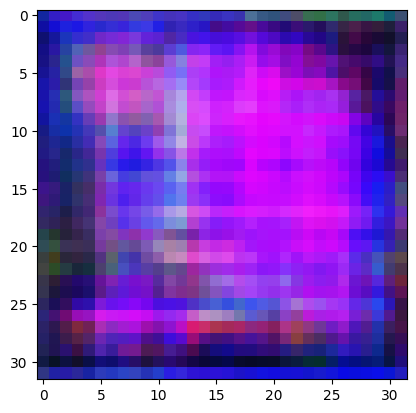

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.052362434714045746


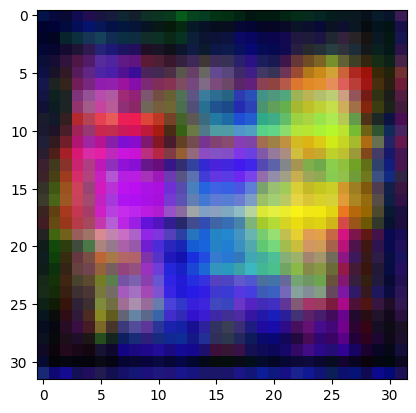

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.04167494519920012


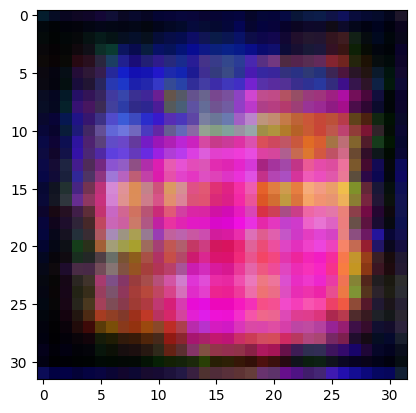

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.037604792425964054


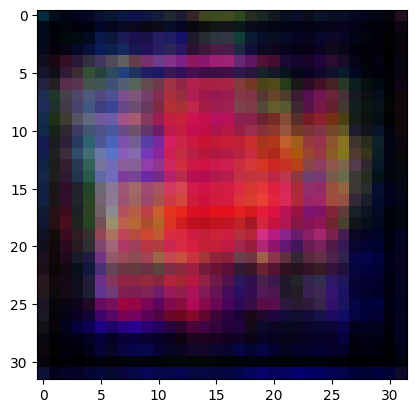

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.0353530952933082


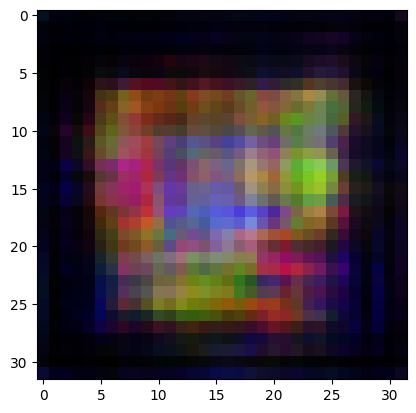

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.0341124234610046


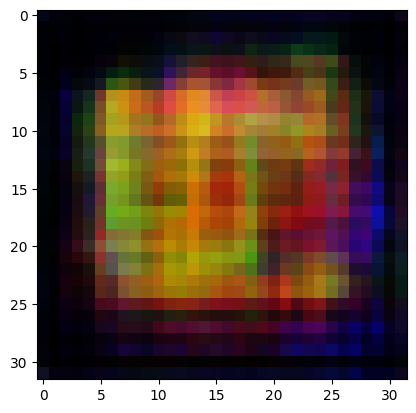

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.0332736765706776


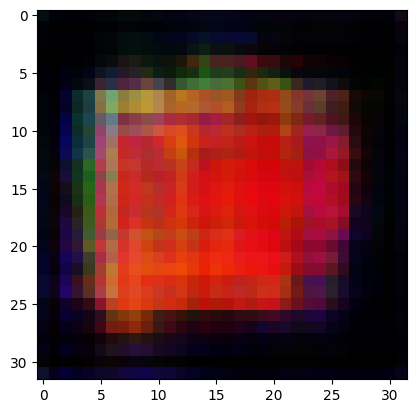

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.03275098452636475


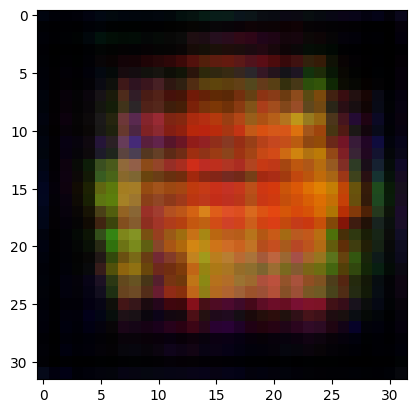

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.03241400019354115


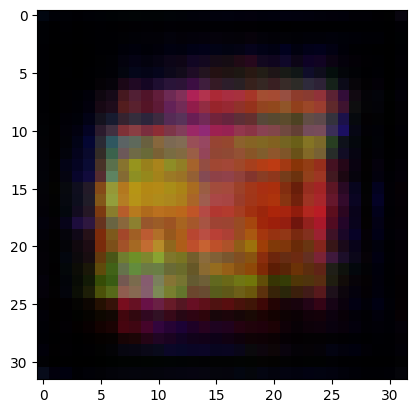

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.032120190149637774


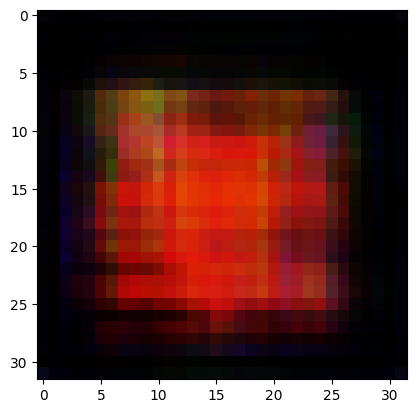

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.03203801534428502


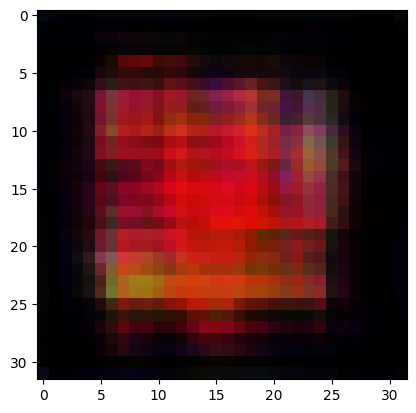

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.03181442963761209


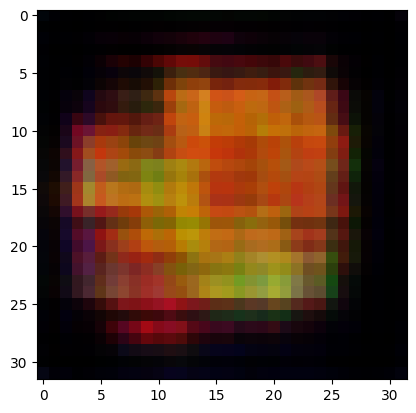

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.03171816787314467


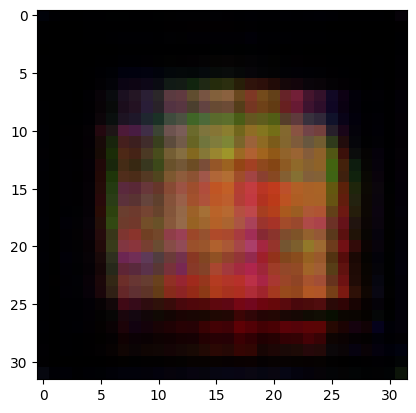

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.03163022006847474


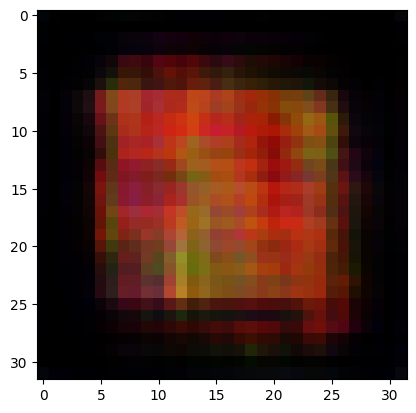

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.031500138260144535


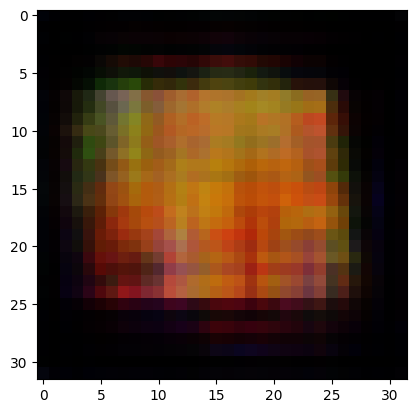

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.03143628316604539


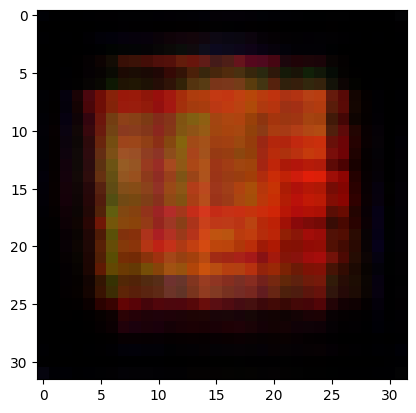

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.031363507309233644


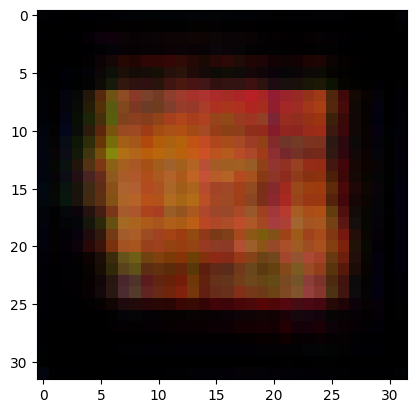

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.0312723203605374


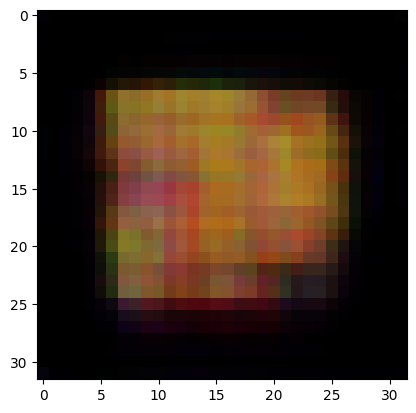

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.031220057810642333


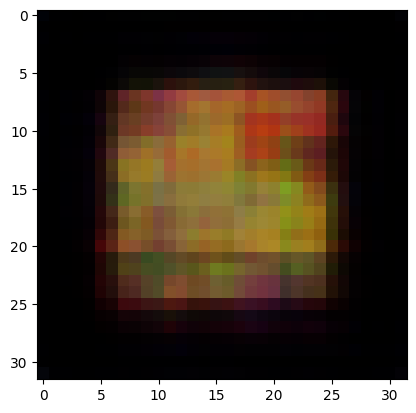

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.031223724647599867


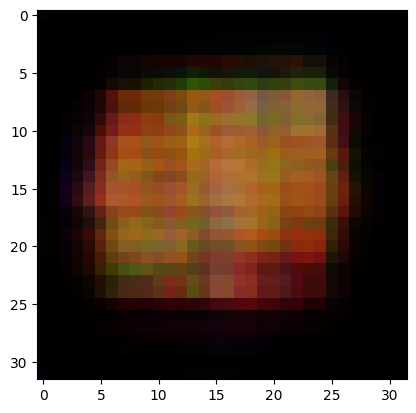

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.031199910980186714


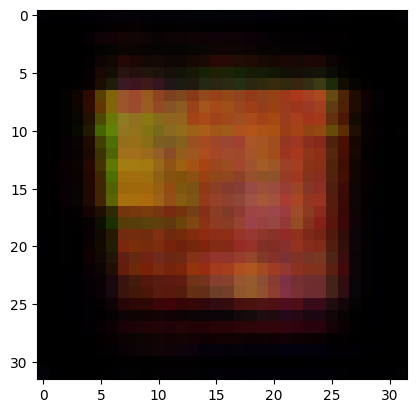

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.031082149701928987


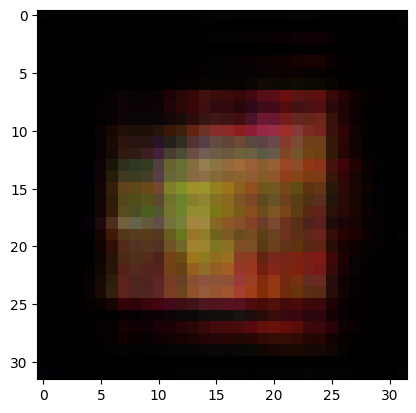

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.03105613724153826


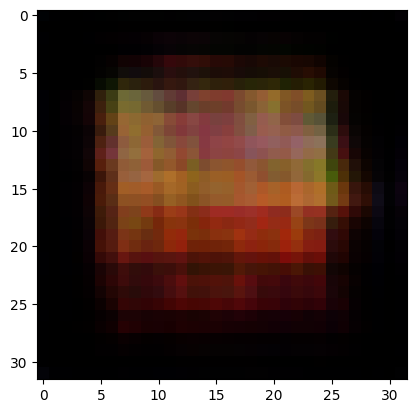

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.030985814879009


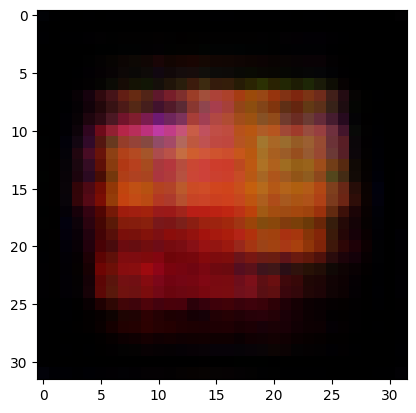

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.030992279746148235


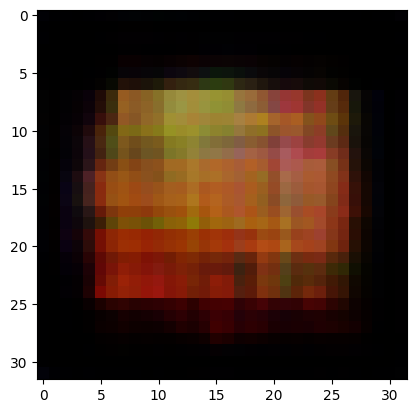

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.03084258735179901


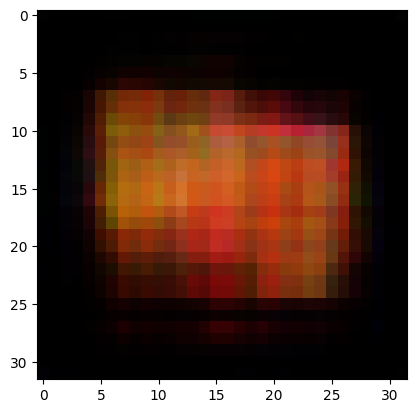

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.030807538110162513


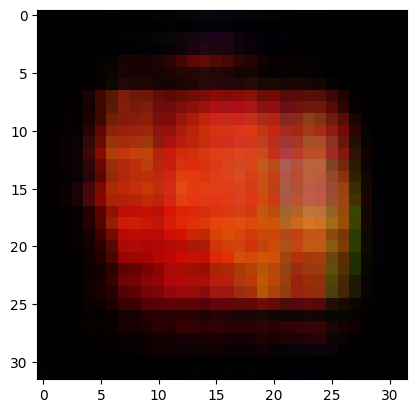

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.030823311564938123


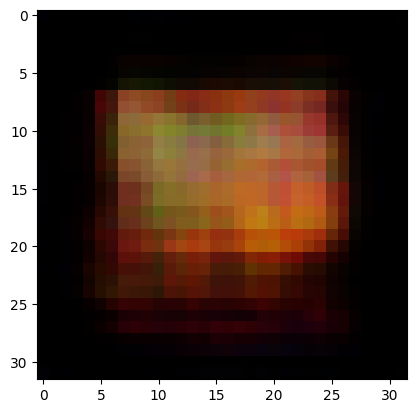

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.030733092040415633


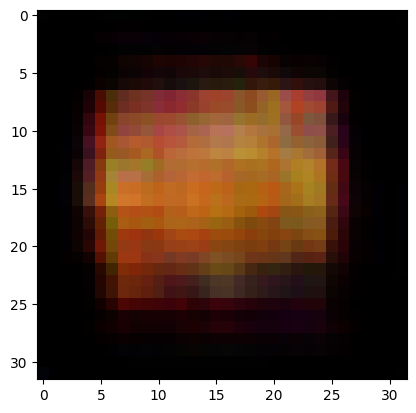

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.030780625264376204


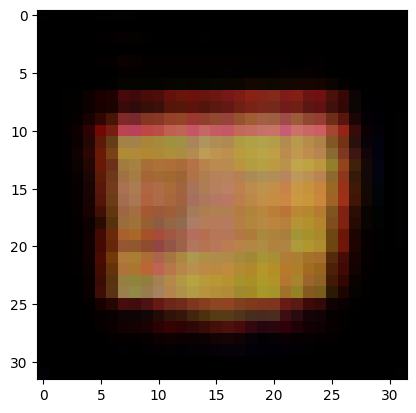

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.030724523675362797


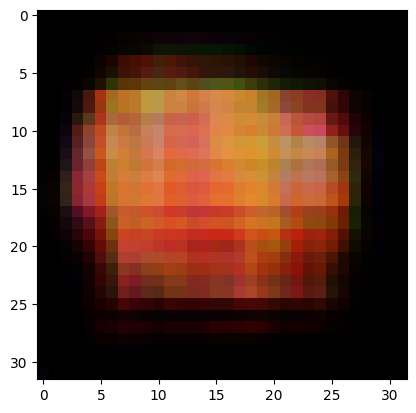

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.030642641794602604


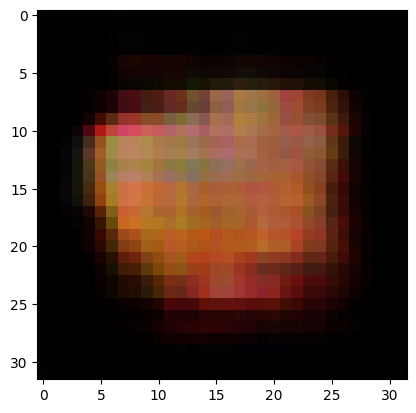

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.030602372245283317


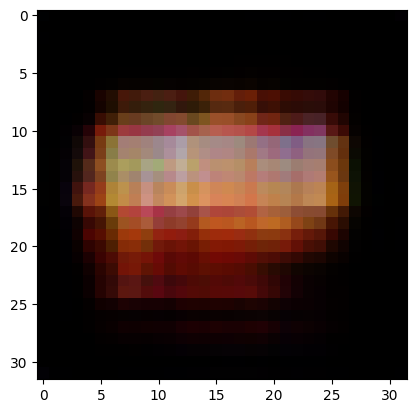

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.030616365422476206


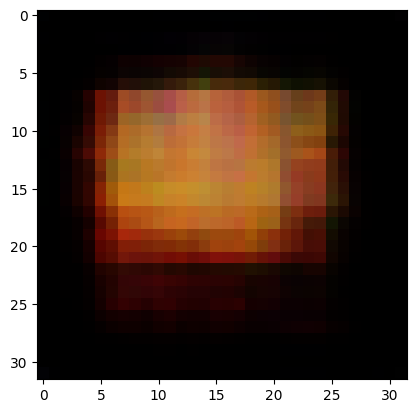

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.030576912410738188


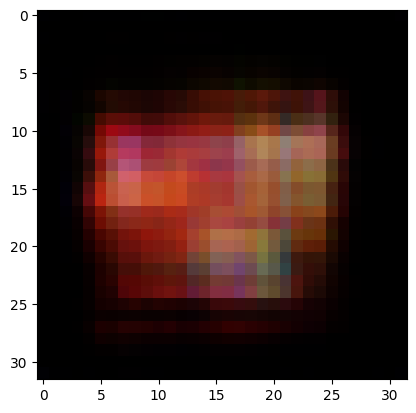

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.03053351884777709


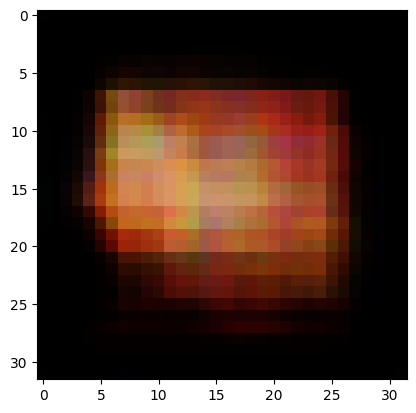

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.03049278331645014


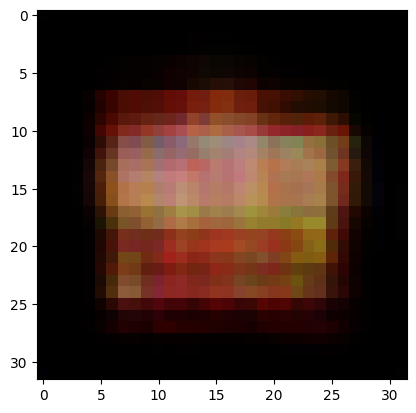

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.030540424401133793


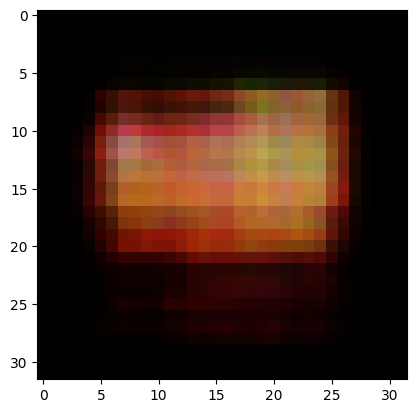

  0%|          | 0/56 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
from torch.optim import Adam
from tqdm.auto import tqdm

model = VAE(z_dim=64)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 100 # Try more!

for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, device)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss}")
        
        sample(model)